In [1]:
!pip install numpy pandas librosa matplotlib scikit-learn tqdm soundfile

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
DATASET_DIR = r"C:/Users/vansh/OneDrive/Desktop/SHL_project/dataset"
AUDIO_TRAIN_DIR = r"C:/Users/vansh/OneDrive/Desktop/SHL_project/dataset/audios/train"
AUDIO_TEST_DIR = r"C:/Users/vansh/OneDrive/Desktop/SHL_project/dataset/audios/test"
TRAIN_CSV = r"C:/Users/vansh/OneDrive/Desktop/SHL_project/dataset/csvs/train.csv"
TEST_CSV = r"C:/Users/vansh/OneDrive/Desktop/SHL_project/dataset/csvs/test.csv"

In [4]:
print(os.path.exists(AUDIO_TRAIN_DIR))
print(os.path.exists(AUDIO_TEST_DIR))
print(os.path.exists(TRAIN_CSV))
print(os.path.exists(TEST_CSV))

True
True
True
True


In [5]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df.head()

,filename,label
0,audio_173,3.0
1,audio_138,3.0
2,audio_127,2.0
3,audio_95,2.0
4,audio_73,3.5


In [6]:
def extract_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=16000)
        if len(y) < sr * 2: 
            return None
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        features = np.hstack([
            mfcc.mean(axis=1),
            mfcc.std(axis=1)
        ])
        return features
    except Exception:
        return None

In [7]:
X = []
y = []
for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    filename = row['filename']
    if not filename.endswith(".wav"):
        filename += ".wav"
    path = os.path.join(AUDIO_TRAIN_DIR, filename)
    features = extract_features(path)
    if features is not None:
        X.append(features)
        y.append(row['label'])
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

  0%|                                                                                          | 0/409 [00:00<?, ?it/s]C:\Users\vansh\AppData\Local\Temp\ipykernel_16464\1505342839.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=16000)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  1%|▌                                                                                 | 3/409 [00:04<08:48,  1.30s/it]C:\Users\vansh\AppData\Local\Temp\ipykernel_16464\1505342839.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=16000)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audi

(276, 40) (276,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
X, y, test_size=0.2, random_state=42
)

In [9]:
model = RandomForestRegressor(
n_estimators=200,
random_state=42,
n_jobs=-1
)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [10]:
y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
print(f"Training RMSE: {rmse:.4f}")

Training RMSE: 0.6963


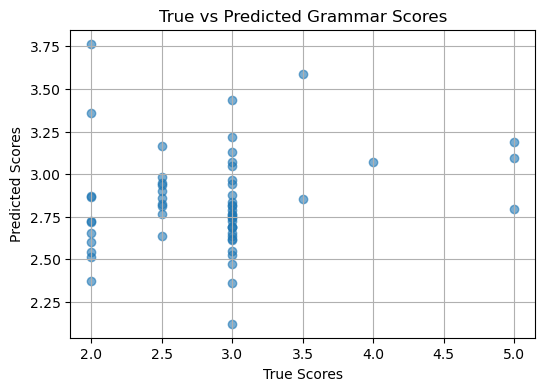

In [11]:
plt.figure(figsize=(6,4))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.title("True vs Predicted Grammar Scores")
plt.grid()
plt.show()

In [12]:
X_test = []
test_filenames = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    filename = row['filename']
    if not filename.endswith(".wav"):
        filename += ".wav"
    path = os.path.join(AUDIO_TEST_DIR, filename)
    features = extract_features(path)
    if features is not None:
        X_test.append(features)
        test_filenames.append(row['filename'])

  3%|██▍                                                                               | 6/197 [00:00<00:20,  9.54it/s]C:\Users\vansh\AppData\Local\Temp\ipykernel_16464\1505342839.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=16000)
C:\Users\vansh\AppData\Roaming\Python\Python313\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:17<00:00, 11.40it/s]


In [13]:
X_test = np.array(X_test)
print(X_test.shape)

(165, 40)


In [14]:
test_predictions = model.predict(X_test)
test_predictions = np.clip(test_predictions, 0, 5)

In [15]:
submission = pd.DataFrame({
    "filename": test_filenames,
    "label": test_predictions
})
submission.to_csv("submission.csv", index=False)
submission.head()

,filename,label
0,audio_141,2.9300
1,audio_114,2.5525
2,audio_17,3.3125
3,audio_76,3.9050
4,audio_156,2.9575
